In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns

# BNN Modules
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
from sklearn.model_selection import train_test_split

from pyro.infer import MCMC, NUTS

from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from tqdm.auto import trange, tqdm

from tqdm.auto import trange

/usr/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ground_motion = pd.read_pickle("data/processed_ground_motion_PGA.pkl")
interest_index = (ground_motion['Earthquake Magnitude'] > 6.0) & (ground_motion['Earthquake Magnitude'] < 7.0)
ground_motion2 = ground_motion[interest_index]
Sample_Size = len(ground_motion2.index)
DNN_param = pickle.load(open('data/DNN_param.pkl', 'rb'))

In [3]:
def datasets_creation(NN=Sample_Size):
	X = np.zeros([NN,2])
	y = np.zeros(NN)
	y[:] = np.log(ground_motion2['PGA (g)'].values)
	X[:,0] = ground_motion2[['EpiD (km)']].values.T
	X[:,1] = ground_motion2[['Vs30 (m/s) selected for analysis']].values.T
	# We added shuffling to introduce stochasticity
	#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, shuffle=True)
	X_train = torch.from_numpy(X).float()
	y_train = torch.from_numpy(y).float()
	return X_train, y_train


In [4]:
class BNN(PyroModule):
    def __init__(self, in_dim=2, out_dim=1, hid_dim=10, n_hid_layers=5, prior_scale=5.):
        super().__init__()
        self.activation = nn.Tanh()
        self.layer_sizes = [in_dim] + n_hid_layers * [hid_dim] + [out_dim]
        layer_list = [PyroModule[nn.Linear](self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = PyroModule[torch.nn.ModuleList](layer_list)

        for layer_idx, layer in enumerate(self.layers):
            layer.weight = PyroSample(dist.Normal(0., prior_scale * np.sqrt(2 / self.layer_sizes[layer_idx])).expand(
                [self.layer_sizes[layer_idx + 1], self.layer_sizes[layer_idx]]).to_event(2))
            layer.bias = PyroSample(dist.Normal(0., prior_scale).expand([self.layer_sizes[layer_idx + 1]]).to_event(1))

    def forward(self, x, y=None):
        x = self.activation(self.layers[0](x))
        for layer in self.layers[1:-1]:
            x = self.activation(layer(x))
        mu = self.layers[-1](x).squeeze()
        sigma = pyro.sample("sigma", dist.Gamma(0.5, 1))

        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu

In [15]:
def plot_predictions(preds):
    y_pred = torch.exp(preds['obs']).T.detach().numpy().mean(axis=1)
    y_std = torch.exp(preds['obs']).T.detach().numpy().std(axis=1)
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.xlabel("X", fontsize=30)
    plt.ylabel("Y", fontsize=30)
    #y_pred = np.exp(y_pred+0.5*y_std)
    #y_std = np.sqrt((np.exp(y_std**2)-1)*np.exp(2*y_pred+y_std**2))
    for i in range(len(preds['obs'])):
        ax.loglog(10**np.linspace(0,2.5,101), np.exp(preds['obs'][i]), '-', linewidth=1, color="c", alpha=0.25)
    ax.loglog(10**np.linspace(0,2.5,101), y_pred, '-', linewidth=3, color="r", label="predictive mean")
    ax.loglog(10**np.linspace(0,2.5,101), y_pred+y_std, '-', linewidth=3, color="r", label="predictive mean")
    plt.legend(loc=4, fontsize=15, frameon=False)
    plt.show()

In [6]:
pyro.clear_param_store()
X_train, y_train = datasets_creation()
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.7, shuffle=True)
model = BNN(hid_dim=300, n_hid_layers=4, prior_scale=5.)
pyro.set_rng_seed(1234)
mean_field_guide = AutoDiagonalNormal(model)
optimizer = pyro.optim.Adam({"lr": 0.0005})

svi = SVI(model, mean_field_guide, optimizer, loss=Trace_ELBO())
pyro.clear_param_store()

num_epochs = 30000
progress_bar = trange(num_epochs)

train_loss = []
test_loss = []
for epoch in progress_bar:
    loss = svi.step(X_train, y_train)
    loss_test = svi.evaluate_loss(X_test, y_test)
    train_loss.append(loss/X_train.shape[0])
    test_loss.append(loss_test/X_test.shape[0])
    progress_bar.set_postfix(loss=f"{loss / X_train.shape[0]:.3f}")

100%|██████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [33:14<00:00, 15.04it/s, loss=5.095]


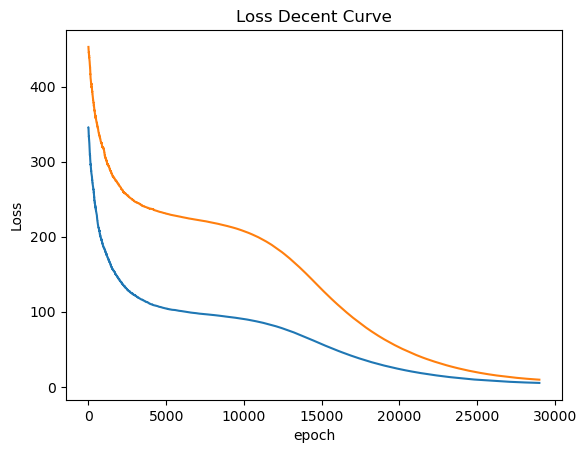

In [25]:
#plt.plot(train_loss, alpha=0.25)
plt.plot(np.convolve(train_loss, np.ones(1000)/1000, mode='valid'))
#plt.plot(test_loss, alpha=0.25)
plt.plot(np.convolve(test_loss, np.ones(1000)/1000, mode='valid'))
plt.title('Loss Decent Curve')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.savefig('LossDecent.pdf')

In [16]:
X_trial = np.zeros([101,2])
X_trial[:,0] = 10**np.linspace(0,2.5,101)
X_trial[:,1] = 100
X_trial = torch.tensor(X_trial, dtype=torch.float32)
predictive = Predictive(model, guide=mean_field_guide, num_samples=1000)
preds = predictive(X_trial)

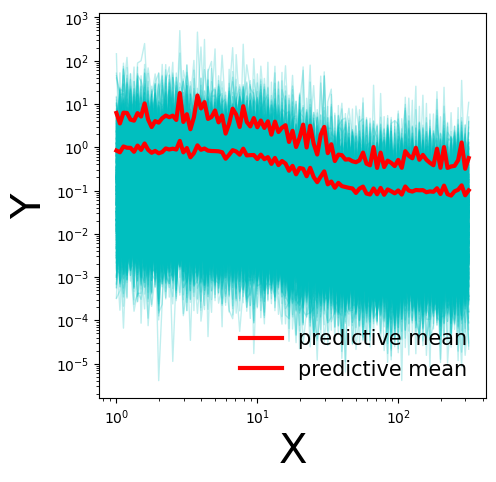

In [17]:
plot_predictions(preds)

In [10]:
pyro.get_param_store().save('bnn05.save')

In [11]:
torch.save(model.state_dict(), 'model_state.pth')

In [26]:
with open("result.pkl", "wb") as f:
    pickle.dump((model, mean_field_guide, svi), f)